<a href="https://colab.research.google.com/github/yeabwang/malaria-diagnosis/blob/main/Malaria_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This model os a binary classification model which classifies cells as infected or not infected.
# Dataset to be used https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets
##### 27,558 cell images - from thin blood smear slides - contains both infected and uninfected cells.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, RandomFlip, RandomRotation, Resizing, Rescaling, RandomZoom
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC, Precision, Recall
from google.colab import drive

In [ ]:
dataset,dataset_info = tfds.load('malaria',as_supervised=True,with_info=True, shuffle_files = True,split=['train'])

In [ ]:
# Spliting our dataset into trianing, validation and testing

def split_dataset(dataset, train_ratio, val_ratio, test_ratio):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()

    train_dataset = dataset.take(int(train_ratio * dataset_size))  # Training set
    val_test_dataset = dataset.skip(int(train_ratio * dataset_size))  # Remaining
    val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))  # Validation set
    test_dataset = val_test_dataset.skip(int(val_ratio * dataset_size))  # Test set

    return train_dataset, val_dataset, test_dataset


In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset,val_dataset,test_dataset = split_dataset(dataset[0],train_ratio,val_ratio,test_ratio)
# print(list(train_dataset.take(1).as_numpy_iterator())), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator())

In [ ]:
# Data visualizer
def visualize(original,augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original Image')
  plt.imshow(original)
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.title('Augmented Image')
  plt.axis('off')
  plt.imshow(augmented)

In [ ]:
original_img, label = next(iter(train_dataset))

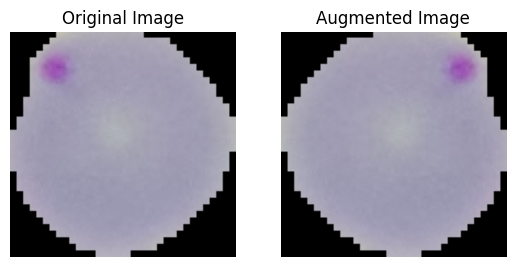

In [ ]:
# Flipping left to right
flipped_img = tf.image.flip_left_right(original_img)

visualize(original_img,flipped_img)

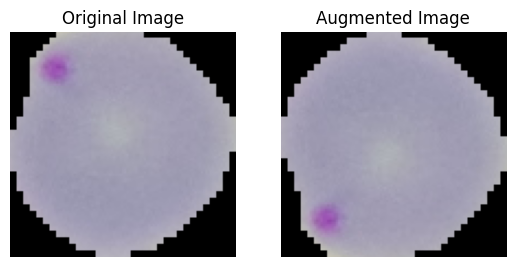

In [ ]:
# Flipping upside down randomly
flipped_upside_img = tf.image.random_flip_up_down(original_img)

visualize(original_img,flipped_upside_img)

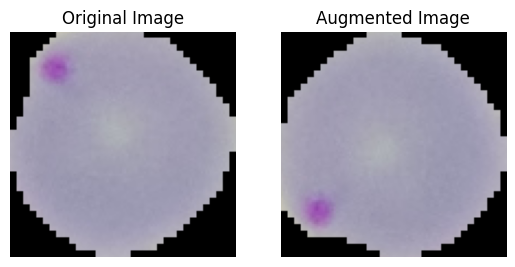

In [ ]:
# Rotating counter clockwise by 90 degrees
rotated_img = tf.image.rot90(original_img)

visualize(original_img,rotated_img)

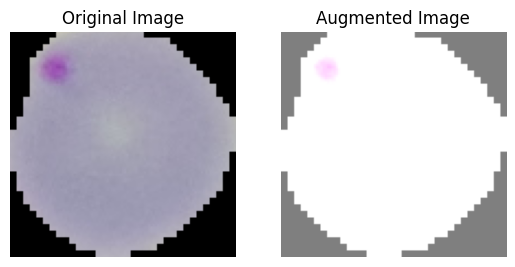

In [ ]:
# Adjusting brightness via some delta (delta has to be between -1 and 1)
# closer to -1 means darker and closer to 1 is brighter
brightened_img = tf.image.adjust_brightness(original_img,0.5)

visualize(original_img,brightened_img)

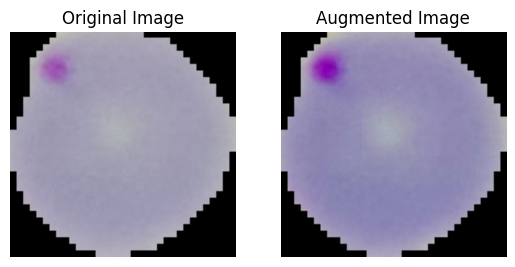

In [ ]:
# Adding a random saturation
# We need to pass the lower and upper bound to the saturation factor
# upper > lower and lower > 0 | otherwise will raise a ValueError

saturated_img = tf.image.random_saturation(original_img,1,2)

visualize(original_img,saturated_img)

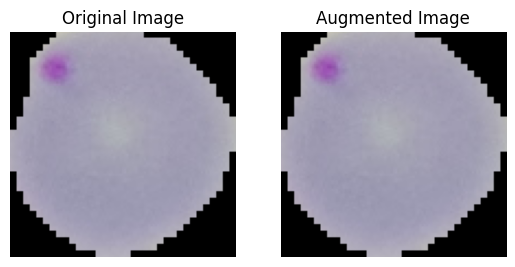

In [ ]:
# Central cropping
# We need to pass a central fraction(0,1) closer to 1 means getting close to the full image and closer to 1 means closer to the very cropped central image
cropped_img = tf.image.central_crop(original_img,1)

visualize(original_img,cropped_img)

In [ ]:
# # Resizing and Rescaling

# image_size = 224

# def resize_rescale(image, label):
#     image = tf.image.resize(image, [image_size, image_size])
#     image = tf.cast(image, tf.float32) / 255.0
#     return image, label

In [ ]:
# # Resizing through layers

# resize_rescale_layers = tf.keras.Sequential([
#     tf.keras.layers.Resizing(image_size, image_size),
#     tf.keras.layers.Rescaling(1./255)
# ])

In [ ]:
image_size = 224

# Resizing and rescaling using layers
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(image_size, image_size),
    tf.keras.layers.Rescaling(1. / 255)
])

augment_layers = tf.keras.Sequential([
    RandomFlip(mode="horizontal_and_vertical"),
    RandomRotation(0.1, fill_mode='reflect'),
    RandomZoom(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05), fill_mode='reflect'),
    tf.keras.layers.RandomContrast(factor=0.1),
])

def add_noise_contrast(image):
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Slight contrast changes
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=image.dtype)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)  # Add Gaussian noise
    return image

In [ ]:
# # Augumentation through keras layers

# augment_layers = tf.keras.Sequential([
#     RandomFlip(mode= "horizontal"),
#     RandomRotation(0.25, 0.2501),
# ])

# def augmented_layers(image,label):
#   image = augment_layers(resize_rescale_layers(image), training = True)
#   return image,label

In [ ]:
# # Defining our augumentation function

# sat_lwr_bound = 1
# sat_upr_bound = 2

# def augmented(image,label):
#   image,label = resize_rescale(image,label)
#   image = tf.image.flip_left_right(image)
#   image = tf.image.random_flip_up_down(image)
#   image = tf.image.random_saturation(image,sat_lwr_bound,sat_upr_bound)

#   return image,label

In [ ]:
# Augmentation combining both tf.image and layers

def augmented_combined(image, label):
    image = resize_rescale_layers(image)
    image = augment_layers(image, training=True)
    image = add_noise_contrast(image)
    return image, label

In [ ]:
# #shuffling and mapping

# batch_size = 32
# buffer_size = 1000

# # For the training dataset
# train_dataset = (
#     train_dataset
#     .shuffle(buffer_size, reshuffle_each_iteration=True)
#     .map(augmented)
#     # .map(augmented_layers)
#     .batch(batch_size)
#     .prefetch(tf.data.AUTOTUNE)
# )

# # For the validation dataset -note: for val dataset - map the resize and rescaled not the augmented
# val_dataset = (val_dataset
#                .shuffle(buffer_size, reshuffle_each_iteration=True)
#                .map(resize_rescale)
#               #  .map(resize_rescale_layers)
#                .batch(batch_size)
#                .prefetch(tf.data.AUTOTUNE))

# # For the test dataset - no need to shuffle, and prefetch(in our case)
# test_dataset = (test_dataset
#                 .map(resize_rescale)
#                 # .map(resize_rescale_layers)
#                 .batch(batch_size))

In [ ]:
batch_size = 32
buffer_size = 1000

# For the training dataset
train_dataset = (
    train_dataset
    .shuffle(buffer_size, reshuffle_each_iteration=True)
    .map(augmented_combined)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# For the validation dataset - only resize and rescale
val_dataset = (
    val_dataset
    .shuffle(buffer_size, reshuffle_each_iteration=True)
    .map(lambda image, label: (resize_rescale_layers(image), label))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# For the test dataset - only resize and rescale
test_dataset = (
    test_dataset
    .map(lambda image, label: (resize_rescale_layers(image), label))
    .batch(batch_size)
)

In [ ]:
# Confirm correct shuffling

train_dataset
val_dataset
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

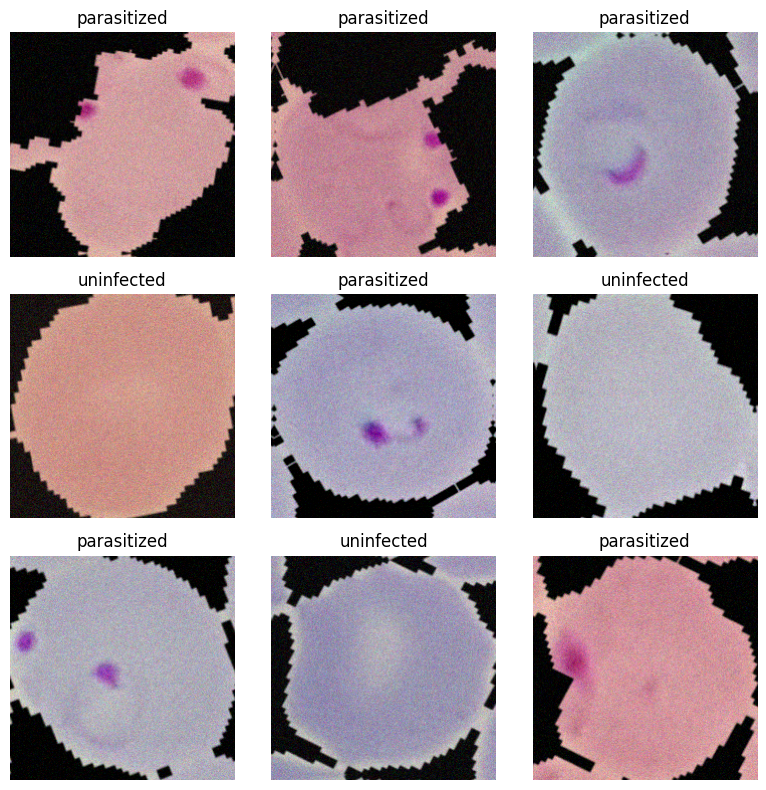

In [ ]:
# Plotting images from the dataset

plt.figure(figsize=(8, 8))
for i, (images, labels) in enumerate(train_dataset.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy())
    plt.title(dataset_info.features['label'].int2str(labels.numpy()))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Building our model

channel_size = 3
dropout_rate = 0.5
regularization_rate = 0.01

model = Sequential([
    InputLayer(shape=(image_size, image_size, channel_size)),

    # First Convolutional Block
    Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer = L2(regularization_rate)),
    MaxPooling2D(pool_size=2, strides=2),

    # Second Convolutional Block
    Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(regularization_rate)),
    MaxPooling2D(pool_size=2, strides=2),

    # Third Convolutional Block (Optional)
    Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer=L2(regularization_rate)),
    MaxPooling2D(pool_size=2, strides=2),

    # Dense Layer
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,261,185 (84.92 MB)

 Trainable params: 22,261,185 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
metrics = [
    BinaryAccuracy(name='accuracy'),
    TruePositives(name='tp'),
    TrueNegatives(name='tn'),
    FalsePositives(name='fp'),
    FalseNegatives(name='fn'),
    AUC(name='auc'),
    Precision(name='precision'),
    Recall(name='recall')
    ]

In [ ]:
# Defining our optimizer, loss function, measurement metrics and compiling our model

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics= metrics,
)

In [ ]:
# # Calculating our loss
# # As one of the arguments in the Binary Cross Entrophy, if we are not sure that our output will be between 0 and one we have to use
# # from_logits = True to tell the model the prediction value might not be in the range of 0 and 1.

# y_true = np.array([0,])
# y_pred = np.array([0.8,])
# bce = BinaryCrossentropy(from_logits = False )

# loss = bce(y_true, y_pred)
# print("Binary Crossentropy Loss:", loss.numpy())


In [ ]:
# class LossCallback(Callback):
#     def on_epoch_end(self, epoch, logs):
#       print("\n For Epoch num {} the model has loss of {}".format(epoch+1, logs["loss"]))

#     def on_batch_end(self, batch, logs):
#       print("\n For Batch num {} the model has loss of {}".format(batch+1, logs))

In [ ]:
# epoch and batch log
csv_callback = CSVLogger('log.csv', separator=',', append=True)

In [ ]:
# Having a smooth linear warmup rate at the starts improve our models stability and leads to a better outcome.
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    min_delta = 0,
    restore_best_weights=True,
    mode = 'auto',
    verbose=1
)

# Speed and stability
# learning_rate_scheduler = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

# Save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

# datasetsize/batch_size = no of epochs

In [ ]:
# Training our model

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[callbacks, csv_callback ],
    verbose=1
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.5108 - auc: 0.5140 - fn: 2270.2888 - fp: 3101.5950 - loss: 1.0339 - precision: 0.5109 - recall: 0.5897 - tn: 2408.4312 - tp: 3259.6821
Epoch 1: val_loss improved from inf to 0.72588, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 335s 471ms/step - accuracy: 0.5108 - auc: 0.5140 - fn: 2274.0508 - fp: 3105.7117 - loss: 1.0336 - precision: 0.5109 - recall: 0.5897 - tn: 2412.3000 - tp: 3263.8855 - val_accuracy: 0.5684 - val_auc: 0.6002 - val_fn: 423.0000 - val_fp: 766.0000 - val_loss: 0.7259 - val_precision: 0.5580 - val_recall: 0.6957 - val_tn: 599.0000 - val_tp: 967.0000 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.5506 - auc: 0.5715 - fn: 2315.8374 - fp: 2509.9551 - loss: 0.7120 - precision: 0.5504 - recall: 0.5980 - tn: 3006.7517 - tp: 3207.4529
Epoch 2: val_loss improved from 0.72588 to 0.49275, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 

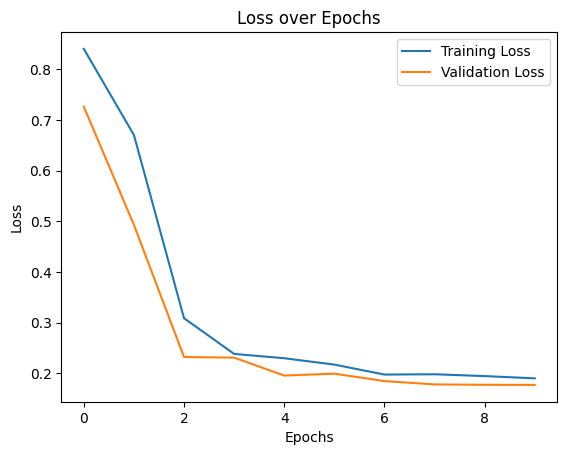

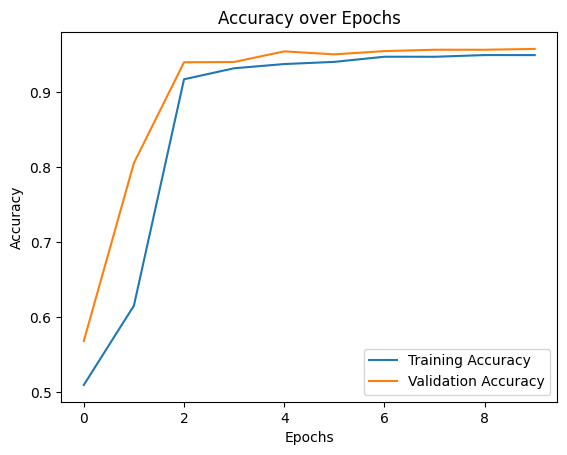

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
# # Evaluate on the validation dataset
# val_loss, val_accuracy, val_auc = model.evaluate(val_dataset, verbose=1)
# print(f"Validation Loss: {val_loss:.4f}")
# print(f"Validation Accuracy: {val_accuracy:.4f}")
# print(f"Validation AUC: {val_auc:.4f}")

# # Evaluate on the test dataset
# test_loss, test_accuracy, test_auc = model.evaluate(test_dataset, verbose=1)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")
# print(f"Test AUC: {test_auc:.4f}")

In [ ]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9553 - auc: 0.9800 - fn: 31.1591 - fp: 36.0568 - loss: 0.1638 - precision: 0.9537 - recall: 0.9573 - tn: 676.3409 - tp: 679.4659


[0.17294076085090637,
 0.9492201805114746,
 1299.0,
 1318.0,
 77.0,
 63.0,
 0.9784172177314758,
 0.9440407156944275,
 0.9537444710731506]

In [ ]:
labels = []
inp = []

# Collect data from the dataset
for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

inp_array = np.concatenate(inp, axis=0)
labels_array = np.concatenate(labels, axis=0)

print(f"Input shape: {inp_array.shape}")
print(f"Labels shape: {labels_array.shape}")

Input shape: (2757, 224, 224, 3)
Labels shape: (2757,)


In [ ]:
predicted = model.predict(inp_array)[:,0,...]
# print(predicted.shape)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


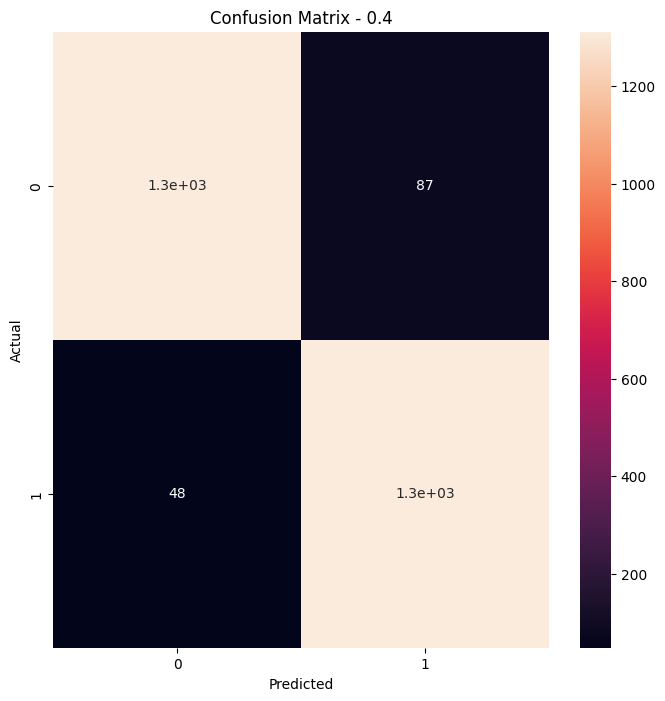

In [ ]:
# Confusion Matrix

threshold = 0.4

con_metrics = confusion_matrix(labels_array, predicted > threshold)
plt.figure(figsize=(8,8))

sns.heatmap(con_metrics, annot=True)
plt.title('Confusion Matrix - {}'.format(threshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
predicted = model.predict(inp_array).flatten()

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


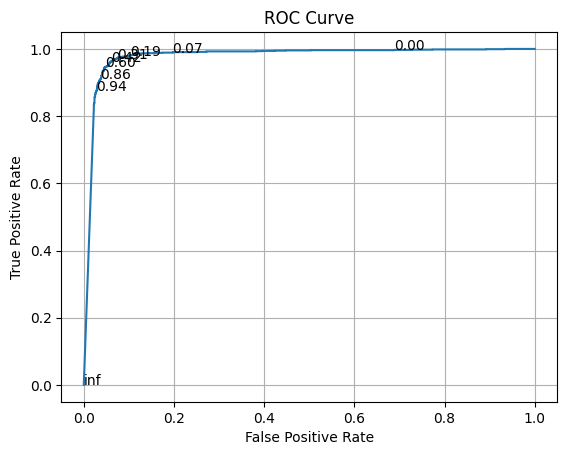

In [ ]:
fp, tp, thresholds = roc_curve(labels_array, predicted)

# Plot ROC curve
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()

# Annotate thresholds
skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], f"{thresholds[i]:.2f}")

plt.show()

In [ ]:
model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


0.86987966

In [ ]:
def labeler(x):
  if(x<0.5):
    return str('Postivie')
  else:
    return str('Negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


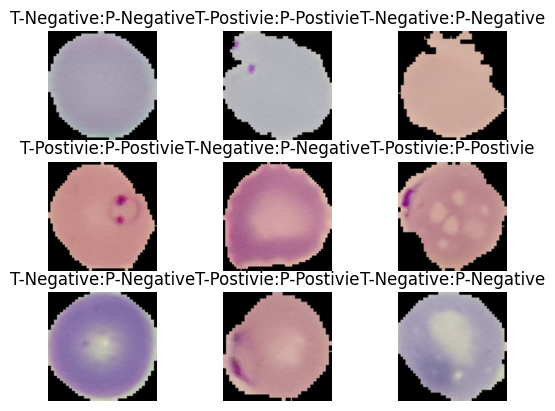

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str("T-"+labeler(label.numpy()[0])) + ":" + str("P-"+labeler(model.predict(image)[0][0])))

  plt.axis('off')

In [ ]:
# Saving our model

drive.mount('/content/drive')

# Specify the path
model_path = '/content/drive/MyDrive/Malaria_Model/Malaria_prediction_version_1.3.keras'

# Save the model to Google Drive
model.save(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
